### Regression: TensorFlow vs Sklearn vs Statsmodels

In [23]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import tensorflow as tf
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

import time

import matplotlib.pyplot as plt

* **Testing example**: Real Estate house price data

In [10]:
data = pd.read_csv("regtestdata.csv")
data = data.drop(columns = ["No", 'X1 transaction date'])
data.head()

,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,32.0,84.87882,10,24.98298,121.54024,37.9
1,19.5,306.59470,9,24.98034,121.53951,42.2
2,13.3,561.98450,5,24.98746,121.54391,47.3
3,13.3,561.98450,5,24.98746,121.54391,54.8
4,5.0,390.56840,5,24.97937,121.54245,43.1


In [11]:
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

#### Sklearn

In [12]:
%time reg = LinearRegression().fit(X, y)
print("coefficient of determination {0}".format(reg.score(X, y)))
print("beta {0} \nintercept {1}".format(reg.coef_, reg.intercept_))

Wall time: 1.99 ms
coefficient of determination 0.5711617064827398
beta [-2.68916833e-01 -4.25908898e-03  1.16302048e+00  2.37767191e+02
 -7.80545273e+00] 
intercept -4945.595113744408


In [13]:
ysklearn = reg.predict(X)
r2_score(y.values, ysklearn)

0.5711617064827398

#### Statsmodels

In [14]:
Xsm = sm.add_constant(X, prepend=False)
%time mod = sm.OLS(y, Xsm)
%time res = mod.fit()

Wall time: 997 µs
Wall time: 996 µs


D:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [15]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                                
======================================================================================
Dep. Variable:     Y house price of unit area   R-squared:                       0.571
Model:                                    OLS   Adj. R-squared:                  0.566
Method:                         Least Squares   F-statistic:                     108.7
Date:                        Wed, 08 Jan 2020   Prob (F-statistic):           9.34e-73
Time:                                14:32:44   Log-Likelihood:                -1492.4
No. Observations:                         414   AIC:                             2997.
Df Residuals:                             408   BIC:                             3021.
Df Model:                                   5                                         
Covariance Type:                    nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
X2 house age                              -0.2689      0.039     -6.896      0.000      -0.346      -0.192
X3 distance to the nearest MRT station    -0.0043      0.001     -5.888      0.000      -0.006      -0.003
X4 number of convenience stores            1.1630      0.190      6.114      0.000       0.789       1.537
X5 latitude                              237.7672     44.948      5.290      0.000     149.409     326.126
X6 longitude                              -7.8055     49.149     -0.159      0.874    -104.422      88.811
const                                  -4945.5951   6211.157     -0.796      0.426   -1.72e+04    7264.269
==============================================================================
Omnibus:                      240.068   Durbin-Watson:                   2.149
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3748.747
Skew:                           2.129   Prob(JB):                         0.00
Kurtosis:                      17.114   Cond. No.                     2.35e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.35e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### TensorFlow (manually)

In [16]:
Xminmax = X.apply(lambda x: (x - x.min())/(x.max() - x.min()))
Xminmax = sm.add_constant(Xminmax, prepend=False)
Xnn = tf.constant(Xminmax.values, dtype = tf.float32)
ynn = tf.constant(y, dtype = tf.float32) 

In [17]:
def mean_squared_error(Y, y_pred):
    return tf.reduce_mean(tf.square(y_pred - Y))
def mean_squared_error_deriv(Y, y_pred):
    return tf.reshape(tf.reduce_mean(2*(y_pred - Y)), [1, 1])
def h(X, weights, bias):
    return tf.tensordot(X, weights, axes=1) + bias

In [18]:
num_epochs = 20
num_samples = X.shape[0]
batch_size = 100
learning_rate = 0.01

dataset = tf.data.Dataset.from_tensor_slices((Xnn, ynn))
# buffer_size , a fixed size buffer from which the next element will be uniformly chosen from
dataset = dataset.shuffle(buffer_size=400).repeat(num_epochs).batch(batch_size)
iterator = dataset.__iter__()

In [19]:
num_features = Xnn.shape[1]
weights = tf.random.normal((num_features, 1))
bias = 0
epochs_plot = []
loss_plot = []

for i in range(num_epochs) :
    epoch_loss = []
    for b in range(int(num_samples/batch_size)):
        x_batch, y_batch = iterator.get_next()
        output = h(x_batch, weights, bias) 
        loss = epoch_loss.append(mean_squared_error(y_batch, output ).numpy())
        dJ_dH = mean_squared_error_deriv(y_batch, output)
        dH_dW = x_batch
        dJ_dW = tf.reduce_mean(dJ_dH*dH_dW)
        dJ_dB = tf.reduce_mean(dJ_dH)
        weights -= learning_rate*dJ_dW
        bias -= learning_rate*dJ_dB
    loss = np.array(epoch_loss).mean()
    epochs_plot.append(i + 1)
    loss_plot.append(loss)
#     if i > 3 and (loss_plot[-2] - loss_plot[-1])/loss_plot[-1] < 0.001:
#         print('Loss is {}'.format(loss))
#         print("early stopping")
#         break
    print('Loss is {}'.format(loss))

Loss is 1358.989013671875
Loss is 980.7584228515625
Loss is 687.59228515625
Loss is 522.5646362304688
Loss is 414.3692321777344
Loss is 316.5061340332031
Loss is 297.97625732421875
Loss is 246.95008850097656
Loss is 237.31556701660156
Loss is 206.25967407226562
Loss is 218.74339294433594
Loss is 210.38148498535156
Loss is 192.06008911132812
Loss is 205.01051330566406
Loss is 184.3499755859375
Loss is 203.98345947265625
Loss is 178.852783203125
Loss is 185.07608032226562
Loss is 191.60342407226562
Loss is 199.62747192382812


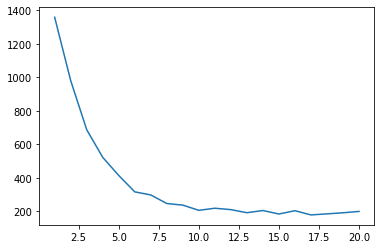

In [20]:
plt.plot(epochs_plot, loss_plot) 
plt.show()

In [21]:
weights

<tf.Tensor: id=2904, shape=(6, 1), dtype=float32, numpy=
array([[6.0631566],
       [7.881733 ],
       [7.380377 ],
       [6.316416 ],
       [7.174367 ],
       [8.993184 ]], dtype=float32)>

In [22]:
output = h(Xnn, weights, bias) 

* compare results

In [24]:
mean_squared_error(y.values, ysklearn)

79.20185189210986

In [25]:
r2_score(y.values, ysklearn)

0.5711617064827398

In [26]:
mean_squared_error(y.values, np.array(output).ravel())

166.152724132257

In [27]:
r2_score(y.values, np.array(output).ravel())

0.10036635535766536

#### TensorFlow.Keras

In [30]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, activation = 'linear', input_shape=[6])
])
optimizer = tf.keras.optimizers.SGD(0.01)
model.compile(loss = 'mean_squared_error',
              optimizer = optimizer,
              metrics = ['mean_absolute_error', 'mean_squared_error'])
model.fit(Xnn, ynn, epochs = 80)

Train on 414 samples
Epoch 1/80
414/414 [==============================] - 0s 597us/sample - loss: 896.6500 - mean_absolute_error: 26.4509 - mean_squared_error: 896.6500
Epoch 2/80
414/414 [==============================] - 0s 43us/sample - loss: 295.1897 - mean_absolute_error: 13.3173 - mean_squared_error: 295.1898
Epoch 3/80
414/414 [==============================] - 0s 41us/sample - loss: 172.0404 - mean_absolute_error: 9.8855 - mean_squared_error: 172.0404
Epoch 4/80
414/414 [==============================] - 0s 36us/sample - loss: 143.9924 - mean_absolute_error: 9.0765 - mean_squared_error: 143.9924
Epoch 5/80
414/414 [==============================] - 0s 41us/sample - loss: 136.0952 - mean_absolute_error: 8.8789 - mean_squared_error: 136.0952
Epoch 6/80
414/414 [==============================] - 0s 34us/sample - loss: 132.7646 - mean_absolute_error: 8.7889 - mean_squared_error: 132.7646
Epoch 7/80
414/414 [==============================] - 0s 39us/sample - loss: 130.2836 - mean_a

414/414 [==============================] - 0s 26us/sample - loss: 88.2962 - mean_absolute_error: 6.7128 - mean_squared_error: 88.2962
Epoch 57/80
414/414 [==============================] - 0s 29us/sample - loss: 87.9580 - mean_absolute_error: 6.7244 - mean_squared_error: 87.9580
Epoch 58/80
414/414 [==============================] - 0s 29us/sample - loss: 87.7580 - mean_absolute_error: 6.6752 - mean_squared_error: 87.7580
Epoch 59/80
414/414 [==============================] - 0s 29us/sample - loss: 87.6155 - mean_absolute_error: 6.6978 - mean_squared_error: 87.6154
Epoch 60/80
414/414 [==============================] - 0s 31us/sample - loss: 87.4292 - mean_absolute_error: 6.6308 - mean_squared_error: 87.4292
Epoch 61/80
414/414 [==============================] - 0s 36us/sample - loss: 87.1647 - mean_absolute_error: 6.6502 - mean_squared_error: 87.1647
Epoch 62/80
414/414 [==============================] - 0s 36us/sample - loss: 87.0084 - mean_absolute_error: 6.6526 - mean_squared_error

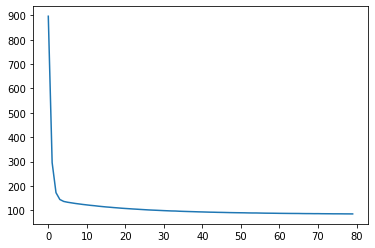

In [31]:
plt.plot(model.history.epoch, model.history.history['loss'])

In [32]:
mean_squared_error(y.values, np.array(model.predict(Xnn)).ravel())

84.63828301314209

In [33]:
r2_score(y.values, np.array(model.predict(Xnn)).ravel())

0.5417261593449861

#### TensorFlow.Keras Deep Learning

In [42]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

scaler = MinMaxScaler()
scaler.fit(X_train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [43]:
X_train_minmax = scaler.transform(X_train)
X_test_minmax = scaler.transform(X_test)

In [44]:
X_train_minmax = sm.add_constant(X_train_minmax, prepend=False)
X_test_minmax = sm.add_constant(X_test_minmax, prepend=False)

In [45]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation = 'relu', input_shape=[6]),
    tf.keras.layers.Dense(64, activation = 'relu', input_shape=[64]),
    tf.keras.layers.Dense(1)
])
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss = 'mean_squared_error',
              optimizer = optimizer,
              metrics = ['mean_squared_error'])
model.fit(X_train_minmax, y_train.values, epochs = 50)

Train on 289 samples
Epoch 1/50
289/289 [==============================] - 0s 1ms/sample - loss: 1417.4486 - mean_squared_error: 1417.4485
Epoch 2/50
289/289 [==============================] - 0s 41us/sample - loss: 369.6510 - mean_squared_error: 369.6509
Epoch 3/50
289/289 [==============================] - 0s 45us/sample - loss: 273.5345 - mean_squared_error: 273.5345
Epoch 4/50
289/289 [==============================] - 0s 52us/sample - loss: 201.6184 - mean_squared_error: 201.6184
Epoch 5/50
289/289 [==============================] - 0s 48us/sample - loss: 136.8303 - mean_squared_error: 136.8303
Epoch 6/50
289/289 [==============================] - 0s 52us/sample - loss: 118.8896 - mean_squared_error: 118.8896
Epoch 7/50
289/289 [==============================] - 0s 52us/sample - loss: 106.5707 - mean_squared_error: 106.5707
Epoch 8/50
289/289 [==============================] - 0s 52us/sample - loss: 106.1355 - mean_squared_error: 106.1355
Epoch 9/50
289/289 [======================

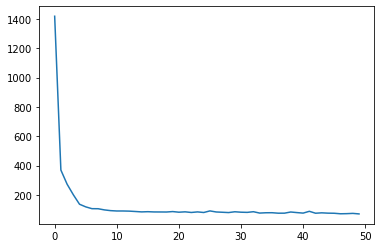

In [46]:
plt.plot(model.history.epoch, model.history.history['loss'])

In [47]:
y_train_pred = np.array(model.predict(X_train_minmax)).ravel()
y_test_pred = np.array(model.predict(X_test_minmax)).ravel()

In [48]:
r2_score(y_train, y_train_pred)

0.6360073978742543

In [49]:
r2_score(y_test, y_test_pred)

0.6584142389208574